# Global Setting

In [313]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [381]:
result_file_path = '../aggrdet/temp/quality-eval.jl'

import json

with open(result_file_path, 'r') as file_reader:
    results = [json.loads(line) for line in file_reader]

In [382]:
# group aggregations according to their error level
annotations = [result['aggregation_annotations'] for result in results]

error_bounds = {}
for ans in annotations:
    if not ans:
        continue
    for an in ans:
        if an['operator'] != 'Sum' and an['operator'] != 'Subtract':
            continue
        error_level = an['error_bound']
        error_bounds[error_level] = 1 if error_level not in error_bounds else error_bounds[error_level] + 1
    
error_bounds = {k: v for k, v in sorted(error_bounds.items(), key=lambda item: item[0])}

# number of all valid aggregations
num_valid = sum([v for k, v in error_bounds.items() if k <= 10])
print('Number of sum or subtract aggregations whose error level is less to or equal to 10: %d' % (num_valid))
print(error_bounds)

Number of sum or subtract aggregations whose error level is less to or equal to 10: 2131
{0.0: 1553, 0.01: 34, 0.02: 2, 0.03: 2, 0.04: 1, 0.1: 99, 0.2: 13, 0.3: 2, 0.4: 2, 0.5: 5, 0.6: 1, 1.0: 202, 1.1: 1, 1.2: 1, 1.3: 1, 1.6: 1, 1.7: 2, 2.0: 19, 2.3: 1, 3.0: 38, 3.9: 1, 4.0: 1, 4.9: 1, 5.0: 93, 5.3: 1, 6.0: 19, 7.0: 1, 8.2: 1, 8.5: 1, 9.0: 6, 9.8: 1, 10.0: 25, 12.0: 1, 13.0: 1, 15.0: 11, 17.0: 1, 18.0: 1, 19.0: 2, 20.0: 7, 21.0: 1, 22.0: 2, 23.1: 1, 26.0: 1, 28.2: 1, 37.9: 1, 40.0: 1, 41.2: 1, 49.0: 1, 51.9: 1, 56.0: 1, 65.0: 1, 67.0: 1, 68.0: 1, 79.3: 1, 96.0: 1, 100.0: 9, 107.0: 1, 123.0: 1, 153.6: 1, 159.0: 1, 160.0: 1, 182.6: 1, 197.0: 1, 198.2: 1, 202.0: 1, 283.0: 1, 289.0: 1, 296.2: 1, 326.0: 1, 415.0: 1, 441.0: 1, 444.0: 1, 475.0: 1, 497.0: 1, 549.0: 1, 589.0: 1, 617.0: 1, 629.6: 1, 643.0: 1, 656.0: 1, 893.0: 1, 901.0: 1, 983.0: 1, 984.0: 1, 1049.0: 1, 1095.0: 1, 1135.0: 1, 1139.0: 1, 1231.0: 2, 1251.0: 1, 1455.0: 1, 1904.0: 1, 1924.0: 1, 2064.0: 1, 2573.0: 1, 2678.0: 1, 5248.0

In [383]:
correctness = []
for result in results:
    correct = result['correct']
    incorrect = result['incorrect']
    if len(correct) == 0 and len(incorrect) == 0:
        continue
    correctness.append([result['file_name'], [len(correct), len(incorrect)], len(correct) / (len(incorrect) + len(correct))])

In [385]:
# correctness

In [386]:
import numpy as np

intervals = np.linspace(0,1,11)

intervals

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [387]:
number_files_correct_gt_percent = []

for percent in intervals:
    satisfied_files = [f for f in correctness if f[2] >= percent]
    number_files_correct_gt_percent.append([percent, len(satisfied_files)])

In [388]:
error_level_thresholds = [0, 0.1, 1, 5, 10, 20, 100]
for result in results:
    annotations = result['aggregation_annotations']
    if not annotations:
        result['annotations_coverage'] = {}
        continue
    coverage = {}
    num_annotations = len([annotation for annotation in annotations if annotation['operator'] == 'Sum' or annotation['operator'] == 'Subtract'])
    for threshold in error_level_thresholds:
        for annotation in annotations:
            if annotation['operator'] != 'Sum' and annotation['operator'] != 'Subtract':
                continue
            if annotation['error_bound'] <= threshold:
                coverage[threshold] = 1 if threshold not in coverage else coverage[threshold] + 1
    for c in coverage:
        coverage[c] = coverage[c] / num_annotations
    result['annotations_coverage'] = coverage

In [389]:
coverage_all_thresholds = {}
for inspected_level in error_level_thresholds:
    num_covered = 0
    for result in results:
        coverage = result['annotations_coverage']
        if inspected_level in coverage:
            if coverage[inspected_level] == 1.0:
                num_covered += 1
    coverage_all_thresholds[inspected_level] = num_covered
    
# {0: 47, 0.1: 59, 1: 88, 5: 105, 10: 116, 20: 126, 100: 133}
coverage_all_thresholds

{0: 47, 0.1: 59, 1: 88, 5: 105, 10: 116, 20: 126, 100: 133}

In [420]:
from glob import glob

data_path = '../aggrdet/results/'

import os

# cwd = os.getcwd()

# os.chdir(data_path)

legended_y_error_bounded = []
legended_y = []

x = intervals
y = {}
y_error_bounded = {}

for file in glob(os.path.join(data_path, 'quality-eval-error-level-*')):
    file_name = file.replace(data_path, '').replace('.jl', '').replace('quality-eval-', '')
    with open(file, 'r') as file_reader:
        results = [json.loads(line) for line in file_reader]
        num_ars_error_bounded = 0
        num_ars = 0
        for result in results:
            error_level = result['used_error_level']
            gts = result['aggregation_annotations']
            satisfied_error_bounded = []
            satisfied = []
            if not gts:
                continue
            for gt in gts:
                if gt['operator'] != 'Sum' and gt['operator'] != 'Subtract':
                    continue
                satisfied.append(gt)
                if gt['error_bound'] <= error_level:
                    satisfied_error_bounded.append(gt)
            if len(satisfied_error_bounded) == 0 or len(satisfied) == 0:
                continue
            num_ars_error_bounded += len(satisfied_error_bounded)
            correct_error_bounded = len(result['correct_error_bounded'])
            incorrect_error_bounded = len(result['incorrect_error_bounded'])
            if correct_error_bounded + incorrect_error_bounded != len(satisfied_error_bounded):
                print('Error bounded numbers do not add up.')
                print(result['file_name'])
                break            
            y_error_bounded[result['file_name']] = [correct_error_bounded, incorrect_error_bounded, correct_error_bounded / len(satisfied_error_bounded)]
            num_ars += len(satisfied)
            correct = len(result['correct'])
            incorrect = len(result['incorrect'])
            if correct + incorrect != len(satisfied):
                print('Numbers do not add up.')
                print(result['file_name'])
                break    
            y[result['file_name']] = [correct, incorrect, correct / len(satisfied)]
        z = {}
        z_error_bounded = {}
        for correctness in intervals:
#             z_error_bounded[correctness] = len([k for k, v in y_error_bounded.items() if v[2] >= correctness])
            z_error_bounded[correctness] = len([k for k, v in y_error_bounded.items() if v[2] >= correctness]) / len(y_error_bounded)
    
            z[correctness] = len([k for k, v in y.items() if v[2] >= correctness]) / len(y)
        legended_y_error_bounded.append([file_name, z_error_bounded, num_ars_error_bounded])
        legended_y.append([file_name, z, num_ars])
# os.chdir(cwd)
print([[e[0], e[2]] for e in legended_y_error_bounded])
print([[e[0], e[2]] for e in legended_y])

[['error-level-10', 2131], ['error-level-20', 2155], ['error-level-1', 1916], ['error-level-5', 2076], ['error-level-0', 1553], ['error-level-0.1', 1691]]
[['error-level-10', 2231], ['error-level-20', 2231], ['error-level-1', 2177], ['error-level-5', 2199], ['error-level-0', 2157], ['error-level-0.1', 2167]]


In [417]:
print(z)
print(z_error_bounded)

{0.0: 1.0, 0.2: 0.8951048951048951, 0.4: 0.7902097902097902, 0.6000000000000001: 0.46153846153846156, 0.8: 0.36363636363636365, 1.0: 0.24475524475524477}
{0.0: 1.0, 0.2: 0.8951048951048951, 0.4: 0.8321678321678322, 0.6000000000000001: 0.7202797202797203, 0.8: 0.6013986013986014, 1.0: 0.45454545454545453}


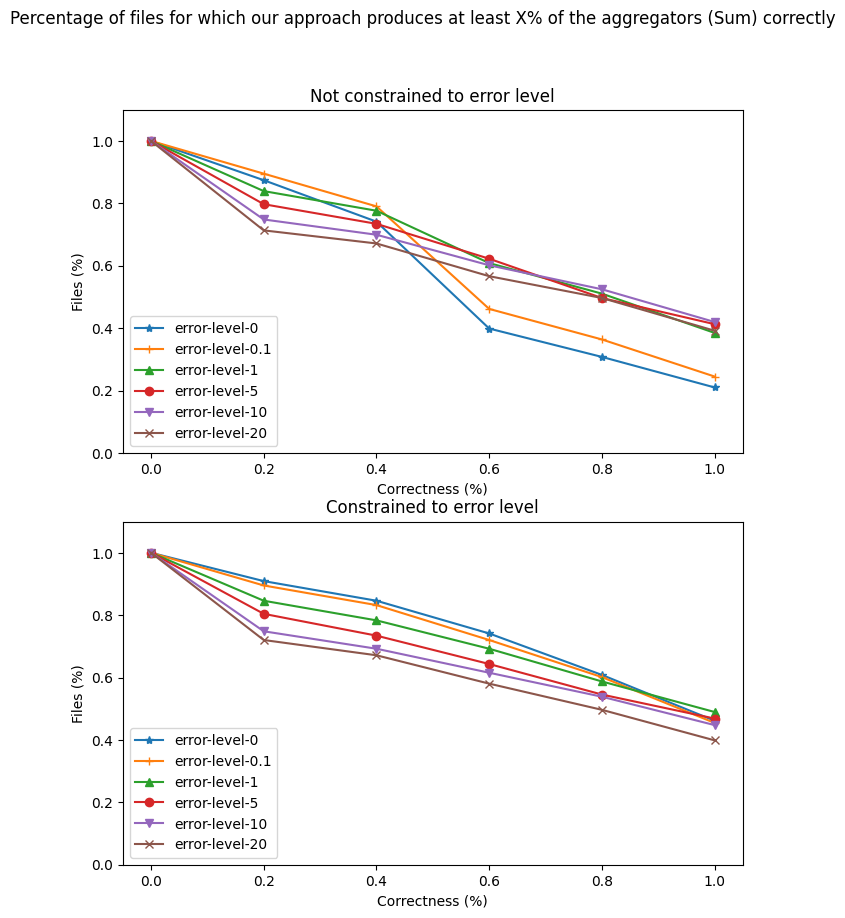

In [429]:
fig, (ax1, ax2) = plt.subplots(2, figsize=[8, 10])

ax1.plot(intervals, [v for k, v in legended_y[4][1].items()], marker='*', label = legended_y[4][0])
ax1.plot(intervals, [v for k, v in legended_y[5][1].items()], marker='+', label = legended_y[5][0])
ax1.plot(intervals, [v for k, v in legended_y[2][1].items()], marker='^', label = legended_y[2][0])
ax1.plot(intervals, [v for k, v in legended_y[3][1].items()], marker='o', label = legended_y[3][0])
ax1.plot(intervals, [v for k, v in legended_y[0][1].items()], marker='v', label = legended_y[0][0])
ax1.plot(intervals, [v for k, v in legended_y[1][1].items()], marker='x', label = legended_y[1][0])
ax1.set_xlabel('Correctness (%)')
ax1.set_ylabel('Files (%)')
ax1.set_ylim([0, 1.1])
ax1.legend(loc='lower left')
ax1.title.set_text('Not constrained to error level')

ax2.plot(intervals, [v for k, v in legended_y_error_bounded[4][1].items()], marker='*', label = legended_y_error_bounded[4][0])
ax2.plot(intervals, [v for k, v in legended_y_error_bounded[5][1].items()], marker='+', label = legended_y_error_bounded[5][0])
ax2.plot(intervals, [v for k, v in legended_y_error_bounded[2][1].items()], marker='^', label = legended_y_error_bounded[2][0])
ax2.plot(intervals, [v for k, v in legended_y_error_bounded[3][1].items()], marker='o', label = legended_y_error_bounded[3][0])
ax2.plot(intervals, [v for k, v in legended_y_error_bounded[0][1].items()], marker='v', label = legended_y_error_bounded[0][0])
ax2.plot(intervals, [v for k, v in legended_y_error_bounded[1][1].items()], marker='x', label = legended_y_error_bounded[1][0])
ax2.set_xlabel('Correctness (%)')
ax2.set_ylabel('Files (%)')
ax2.set_ylim([0, 1.1])
ax2.legend(loc='lower left')
ax2.title.set_text('Constrained to error level')

# Set a title of the current axes.
fig.suptitle('Percentage of files for which our approach produces at least X% of the aggregators (Sum) correctly')

plt.show()

In [491]:
intervals = np.linspace(0, 1, 6)
print('Bins are: %s' % (str(intervals)))

from glob import glob

data_path = '../aggrdet/results/'

import os

legended_y_error_bounded = []

x = intervals
file_percent_dist_correctness = []
file_percent_dist_precision = []
file_percent_dist_recall = file_percent_dist_correctness

file_percent_dist_correctness_error_bounded = []
file_percent_dist_precision_error_bounded = []
file_percent_dist_recall_error_bounded = file_percent_dist_correctness_error_bounded

precision_recall_f1 = []
precision_recall_f1_error_bounded = []

for file in glob(os.path.join(data_path, 'quality-eval-error-level-*')):
    file_name = file.replace(data_path, '').replace('.jl', '').replace('quality-eval-', '')
    cumu_true_positive_error_bounded = 0
    cumu_false_negative_error_bounded = 0
    cumu_false_positive_error_bounded = 0
    cumu_true_positive = 0
    cumu_false_negative = 0
    cumu_false_positive = 0
    with open(file, 'r') as file_reader:
        results = [json.loads(line) for line in file_reader]
        files_error_bounded = {}
        y = {}
        y_error_bounded = {}
        for result in results:
            error_level = result['used_error_level']
            gts = result['aggregation_annotations']
            satisfied_error_bounded = [] # how many aggregations are there in the ground truth that are sum or subtract and have low enough error level
            satisfied = []
            if not gts:
                continue
            for gt in gts:
                if gt['operator'] != 'Sum' and gt['operator'] != 'Subtract':
                    continue
                satisfied.append(gt)
                if gt['error_bound'] <= error_level:
                    satisfied_error_bounded.append(gt)
            if len(satisfied_error_bounded) == 0 or len(satisfied) == 0:
#             if len(satisfied_error_bounded) == 0:
                continue
            files_error_bounded[result['file_name']] = len(satisfied_error_bounded)
            correct_error_bounded = len(result['correct_error_bounded'])
            incorrect_error_bounded = len(result['incorrect_error_bounded'])
            false_positive_error_bounded = len(result['false_positive_error_bounded'])
            if correct_error_bounded + incorrect_error_bounded != len(satisfied_error_bounded):
                print('Error bounded numbers do not add up.')
                print(result['file_name'])
                break
            if correct_error_bounded + false_positive_error_bounded == 0:
                precision_error_bounded = -1
            else:
                precision_error_bounded = correct_error_bounded / (correct_error_bounded + false_positive_error_bounded)
            cumu_true_positive_error_bounded += correct_error_bounded
            cumu_false_negative_error_bounded += incorrect_error_bounded
            cumu_false_positive_error_bounded += false_positive_error_bounded
            y_error_bounded[result['file_name']] = [correct_error_bounded, incorrect_error_bounded, correct_error_bounded / len(satisfied_error_bounded), precision_error_bounded]
            
            correct = len(result['correct'])
            incorrect = len(result['incorrect'])
            false_positive = len(result['false_positive'])
            if correct + incorrect != len(satisfied):
                print('Numbers do not add up.')
                print(result['file_name'])
                break                
            if correct + false_positive == 0:
                precision = -1
            else:
                precision = correct / (correct + false_positive)
            cumu_true_positive += correct
            cumu_false_negative += incorrect
            cumu_false_positive += false_positive
            y[result['file_name']] = [correct, incorrect, correct / len(satisfied), precision]
            
        overall_precision_error_bounded = cumu_true_positive_error_bounded / (cumu_true_positive_error_bounded + cumu_false_positive_error_bounded)
        overall_recall_error_bounded = cumu_true_positive_error_bounded / (cumu_true_positive_error_bounded + cumu_false_negative_error_bounded)
        overall_f1_error_bounded = 2*overall_precision_error_bounded*overall_recall_error_bounded / (overall_precision_error_bounded + overall_recall_error_bounded)
        precision_recall_f1_error_bounded.append([file_name, round(overall_precision_error_bounded, 3), round(overall_recall_error_bounded, 3), 
                                                  round(overall_f1_error_bounded, 3)])
        
        overall_precision = cumu_true_positive / (cumu_true_positive + cumu_false_positive)
        overall_recall = cumu_true_positive / (cumu_true_positive + cumu_false_negative)
        overall_f1 = 2*overall_precision*overall_recall / (overall_precision + overall_recall)
        precision_recall_f1.append([file_name, round(overall_precision, 3), round(overall_recall, 3), round(overall_f1, 3)])
        
        digitized_error_bounded = np.digitize([v[2] for k, v in y_error_bounded.items()], intervals, right=True)
#         file_percent_dist_correctness_error_bounded.append([file_name, [len(digitized_error_bounded[digitized_error_bounded == i]) / len(digitized_error_bounded) for i in range(0, len(intervals))]])
        file_percent_dist_correctness_error_bounded.append([file_name, [len(digitized_error_bounded[digitized_error_bounded == i]) for i in range(0, len(intervals))]])
        digitized_precision_error_bounded = np.digitize([v[3] for k, v in y_error_bounded.items()], intervals, right=True)
#         file_percent_dist_precision_error_bounded.append([file_name, [len(digitized_precision_error_bounded[digitized_precision_error_bounded == i]) / len(digitized_error_bounded)
#                                                                       for i in range(0, len(intervals))]])
        file_percent_dist_precision_error_bounded.append([file_name, [len(digitized_precision_error_bounded[digitized_precision_error_bounded == i]) 
                                                                      for i in range(0, len(intervals))]])
        
        digitized = np.digitize([v[2] for k, v in y.items()], intervals, right=True)
#         file_percent_dist_correctness.append([file_name, [len(digitized[digitized == i]) / len(digitized) for i in range(0, len(intervals))]])
        file_percent_dist_correctness.append([file_name, [len(digitized[digitized == i]) for i in range(0, len(intervals))]])
        digitized_precision = np.digitize([v[3] for k, v in y.items()], intervals, right=True)
        file_percent_dist_precision.append([file_name, [len(digitized_precision[digitized_precision == i]) for i in range(0, len(intervals))]])
#         file_percent_dist_precision.append([file_name, [len(digitized_precision[digitized_precision == i]) / len(digitized_precision) for i in range(0, len(intervals))]])
print(digitized)
print()
print(*file_percent_dist_correctness, sep='\n')
print()
print(*file_percent_dist_precision, sep='\n')
print()
print(digitized_error_bounded)
print()
print(*file_percent_dist_correctness_error_bounded, sep='\n')
print()
print(*file_percent_dist_precision_error_bounded, sep='\n')

Bins are: [0.  0.2 0.4 0.6 0.8 1. ]
[4 0 5 0 5 5 3 3 3 3 5 4 3 3 0 2 3 1 2 3 0 4 2 0 4 1 2 5 5 4 5 2 4 4 5 5 3
 3 2 5 5 2 5 2 3 2 4 1 5 5 5 2 1 5 5 0 4 3 0 2 5 1 3 5 3 5 3 3 2 0 5 4 1 3
 5 5 5 3 5 3 5 3 5 5 5 2 5 3 5 5 3 2 3 3 5 3 5 4 5 5 3 4 3 1 3 5 3 5 5 4 1
 2 4 5 5 3 2 2 2 4 4 5 3 3 3 5 5 5 3 5 3 3 3 3 4]

['error-level-10', [31, 5, 7, 14, 13, 73]]
['error-level-20', [37, 4, 6, 15, 11, 70]]
['error-level-1', [13, 7, 10, 21, 17, 69]]
['error-level-5', [23, 7, 8, 15, 19, 69]]
['error-level-0', [8, 11, 21, 40, 15, 38]]
['error-level-0.1', [8, 8, 18, 38, 17, 46]]

['error-level-10', [31, 7, 9, 6, 19, 71]]
['error-level-20', [37, 7, 3, 12, 18, 66]]
['error-level-1', [13, 6, 4, 12, 15, 87]]
['error-level-5', [23, 10, 4, 13, 18, 73]]
['error-level-0', [8, 3, 0, 4, 18, 100]]
['error-level-0.1', [8, 4, 2, 5, 18, 98]]

[5 0 5 0 5 5 5 4 4 3 5 5 5 0 0 2 5 3 4 5 0 5 5 0 5 2 2 5 5 5 5 2 5 5 5 5 3
 3 5 5 5 5 5 5 4 5 5 2 5 5 5 2 1 5 5 0 4 3 0 4 5 1 5 5 5 5 5 4 3 0 5 4 2 3
 5 5 5 3 5 5 5 0 5 5 5 5 

In [349]:
# stop when encountering an empty cell, error bounded

precision_recall_f1 = [e for e in sorted(precision_recall_f1, key=lambda x: float(x[0].split('error-level-')[1]))]

import pandas

prf = pandas.DataFrame(precision_recall_f1, columns=['error-level', 'precision', 'recall', 'f1'])
prf

,error-level,precision,recall,f1
0,error-level-0,0.862,0.669,0.753
1,error-level-0.1,0.833,0.682,0.750
2,error-level-1,0.737,0.683,0.709
3,error-level-5,0.627,0.646,0.636
4,error-level-10,0.584,0.610,0.597
5,error-level-20,0.601,0.615,0.608


In [482]:
# continue as encountering an empty cell, error bounded

precision_recall_f1_error_bounded = [e for e in sorted(precision_recall_f1_error_bounded, key=lambda x: float(x[0].split('error-level-')[1]))]

import pandas

prf = pandas.DataFrame(precision_recall_f1_error_bounded, columns=['error-level', 'precision', 'recall', 'f1'])
prf

,error-level,precision,recall,f1
0,error-level-0,0.842,0.698,0.763
1,error-level-0.1,0.811,0.705,0.755
2,error-level-1,0.718,0.708,0.713
3,error-level-5,0.589,0.652,0.619
4,error-level-10,0.557,0.627,0.590
5,error-level-20,0.546,0.608,0.575


In [467]:
# this is with empty cell skipping

precision_recall_f1 = [e for e in sorted(precision_recall_f1, key=lambda x: float(x[0].split('error-level-')[1]))]

import pandas

prf = pandas.DataFrame(precision_recall_f1, columns=['error-level', 'precision', 'recall', 'f1'])
prf

,error-level,precision,recall,f1
0,error-level-0,0.843,0.503,0.630
1,error-level-0.1,0.818,0.577,0.677
2,error-level-1,0.725,0.644,0.682
3,error-level-5,0.591,0.620,0.605
4,error-level-10,0.562,0.613,0.586
5,error-level-20,0.550,0.597,0.573


In [469]:
len(digitized_precision)

135

['0.0', '0.2', '0.4', '0.6', '0.8', '1.0']


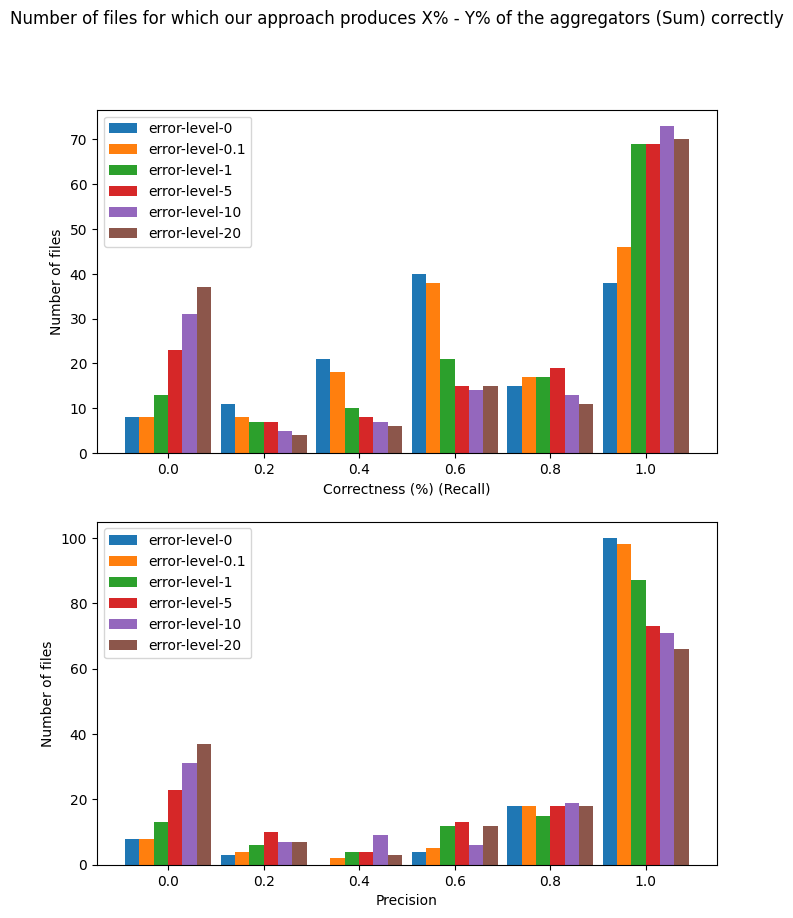

In [492]:
labels = ["%.1f" % round(i, 2) for i in intervals]
print(labels)

x = np.arange(len(labels))
width = 0.15

fig, (ax1, ax2) = plt.subplots(2, figsize=[8, 10])

p11 = ax1.bar(x-2.5*width, file_percent_dist_correctness[4][1], width, label=file_percent_dist_correctness[4][0])
p12 = ax1.bar(x-1.5*width, file_percent_dist_correctness[5][1], width, label=file_percent_dist_correctness[5][0])
p13 = ax1.bar(x-0.5*width, file_percent_dist_correctness[2][1], width, label=file_percent_dist_correctness[2][0])
p14 = ax1.bar(x+0.5*width, file_percent_dist_correctness[3][1], width, label=file_percent_dist_correctness[3][0])
p15 = ax1.bar(x+1.5*width, file_percent_dist_correctness[0][1], width, label=file_percent_dist_correctness[0][0])
p16 = ax1.bar(x+2.5*width, file_percent_dist_correctness[1][1], width, label=file_percent_dist_correctness[1][0])
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_xlabel('Correctness (%) (Recall)')
ax1.set_ylabel('Number of files')
ax1.legend(loc='upper left')

p21 = ax2.bar(x-2.5*width, file_percent_dist_precision[4][1], width, label=file_percent_dist_precision[4][0])
p22 = ax2.bar(x-1.5*width, file_percent_dist_precision[5][1], width, label=file_percent_dist_precision[5][0])
p23 = ax2.bar(x-0.5*width, file_percent_dist_precision[2][1], width, label=file_percent_dist_precision[2][0])
p24 = ax2.bar(x+0.5*width, file_percent_dist_precision[3][1], width, label=file_percent_dist_precision[3][0])
p25 = ax2.bar(x+1.5*width, file_percent_dist_precision[0][1], width, label=file_percent_dist_precision[0][0])
p26 = ax2.bar(x+2.5*width, file_percent_dist_precision[1][1], width, label=file_percent_dist_precision[1][0])
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.set_xlabel('Precision')
ax2.set_ylabel('Number of files')
ax2.legend(loc='upper left')

# Set a title of the current axes.
fig.suptitle('Number of files for which our approach produces X% - Y% of the aggregators (Sum) correctly')


plt.show()

['0.0', '0.2', '0.4', '0.6', '0.8', '1.0']


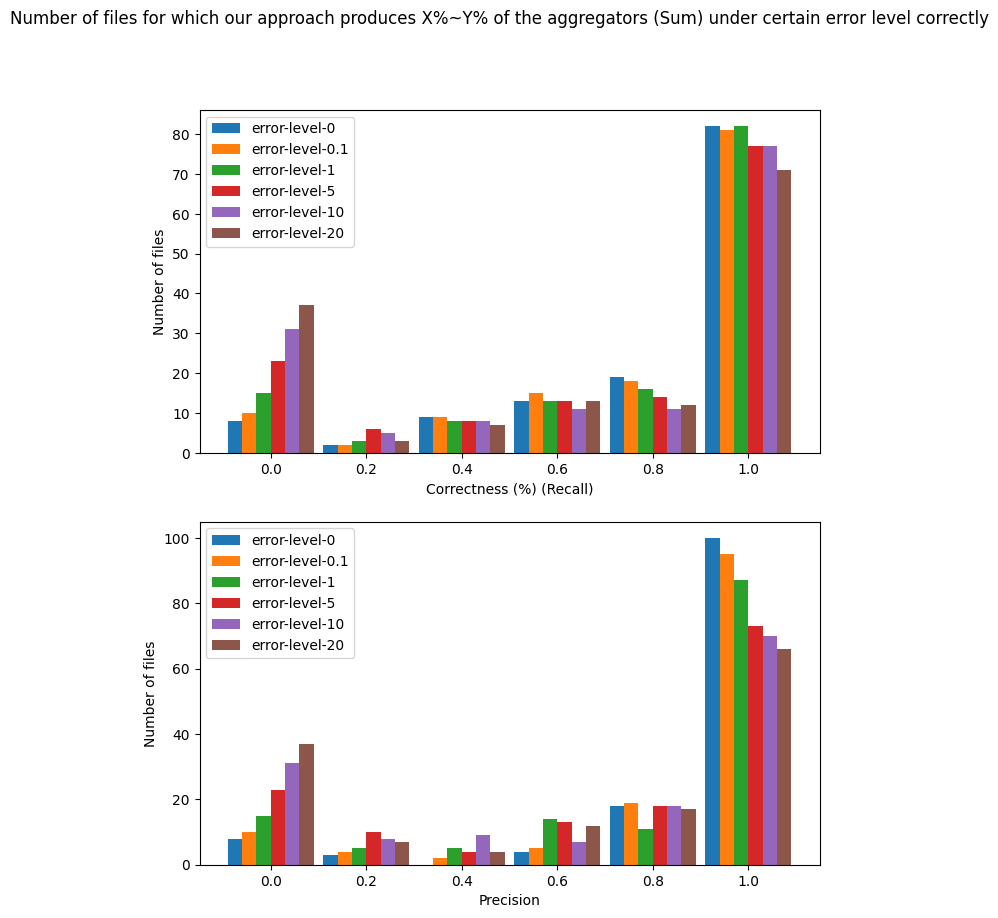

In [494]:
labels = ["%.1f" % round(i, 2) for i in intervals]
print(labels)

x = np.arange(len(labels))
width = 0.15

fig, (ax1, ax2) = plt.subplots(2, figsize=[8, 10])

p11 = ax1.bar(x-2.5*width, file_percent_dist_correctness_error_bounded[4][1], width, label=file_percent_dist_correctness_error_bounded[4][0])
p12 = ax1.bar(x-1.5*width, file_percent_dist_correctness_error_bounded[5][1], width, label=file_percent_dist_correctness_error_bounded[5][0])
p13 = ax1.bar(x-0.5*width, file_percent_dist_correctness_error_bounded[2][1], width, label=file_percent_dist_correctness_error_bounded[2][0])
p14 = ax1.bar(x+0.5*width, file_percent_dist_correctness_error_bounded[3][1], width, label=file_percent_dist_correctness_error_bounded[3][0])
p15 = ax1.bar(x+1.5*width, file_percent_dist_correctness_error_bounded[0][1], width, label=file_percent_dist_correctness_error_bounded[0][0])
p16 = ax1.bar(x+2.5*width, file_percent_dist_correctness_error_bounded[1][1], width, label=file_percent_dist_correctness_error_bounded[1][0])
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_xlabel('Correctness (%) (Recall)')
ax1.set_ylabel('Number of files')
ax1.legend(loc='upper left')

p21 = ax2.bar(x-2.5*width, file_percent_dist_precision_error_bounded[4][1], width, label=file_percent_dist_precision_error_bounded[4][0])
p22 = ax2.bar(x-1.5*width, file_percent_dist_precision_error_bounded[5][1], width, label=file_percent_dist_precision_error_bounded[5][0])
p23 = ax2.bar(x-0.5*width, file_percent_dist_precision_error_bounded[2][1], width, label=file_percent_dist_precision_error_bounded[2][0])
p24 = ax2.bar(x+0.5*width, file_percent_dist_precision_error_bounded[3][1], width, label=file_percent_dist_precision_error_bounded[3][0])
p25 = ax2.bar(x+1.5*width, file_percent_dist_precision_error_bounded[0][1], width, label=file_percent_dist_precision_error_bounded[0][0])
p26 = ax2.bar(x+2.5*width, file_percent_dist_precision_error_bounded[1][1], width, label=file_percent_dist_precision_error_bounded[1][0])
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.set_xlabel('Precision')
ax2.set_ylabel('Number of files')
ax2.legend(loc='upper left')

# Set a title of the current axes.
fig.suptitle('Number of files for which our approach produces X%~Y% of the aggregators (Sum) under certain error level correctly')


plt.show()

In [495]:
file_percent_dist_correctness = [[e[0].replace('error-level-', ''), e[1]] for e in file_percent_dist_correctness]
file_percent_dist_correctness = [e for e in sorted(file_percent_dist_correctness, key=lambda x: float(x[0]))]
print(*file_percent_dist_correctness, sep='\n')
print()

file_percent_dist_precision = [[e[0].replace('error-level-', ''), e[1]] for e in file_percent_dist_precision]
file_percent_dist_precision = [e for e in sorted(file_percent_dist_precision, key=lambda x: float(x[0]))]
print(*file_percent_dist_precision, sep='\n')
print()

file_percent_dist_correctness_error_bounded = [[e[0].replace('error-level-', ''), e[1]] for e in file_percent_dist_correctness_error_bounded]
file_percent_dist_correctness_error_bounded = [e for e in sorted(file_percent_dist_correctness_error_bounded, key=lambda x: float(x[0]))]
print(*file_percent_dist_correctness_error_bounded, sep='\n')
print()

file_percent_dist_precision_error_bounded = [[e[0].replace('error-level-', ''), e[1]] for e in file_percent_dist_precision_error_bounded]
file_percent_dist_precision_error_bounded = [e for e in sorted(file_percent_dist_precision_error_bounded, key=lambda x: float(x[0]))]
print(*file_percent_dist_precision_error_bounded, sep='\n')

['0', [8, 11, 21, 40, 15, 38]]
['0.1', [8, 8, 18, 38, 17, 46]]
['1', [13, 7, 10, 21, 17, 69]]
['5', [23, 7, 8, 15, 19, 69]]
['10', [31, 5, 7, 14, 13, 73]]
['20', [37, 4, 6, 15, 11, 70]]

['0', [8, 3, 0, 4, 18, 100]]
['0.1', [8, 4, 2, 5, 18, 98]]
['1', [13, 6, 4, 12, 15, 87]]
['5', [23, 10, 4, 13, 18, 73]]
['10', [31, 7, 9, 6, 19, 71]]
['20', [37, 7, 3, 12, 18, 66]]

['0', [8, 2, 9, 13, 19, 82]]
['0.1', [10, 2, 9, 15, 18, 81]]
['1', [15, 3, 8, 13, 16, 82]]
['5', [23, 6, 8, 13, 14, 77]]
['10', [31, 5, 8, 11, 11, 77]]
['20', [37, 3, 7, 13, 12, 71]]

['0', [8, 3, 0, 4, 18, 100]]
['0.1', [10, 4, 2, 5, 19, 95]]
['1', [15, 5, 5, 14, 11, 87]]
['5', [23, 10, 4, 13, 18, 73]]
['10', [31, 8, 9, 7, 18, 70]]
['20', [37, 7, 4, 12, 17, 66]]


['0', '0.1', '1', '5', '10', '20']


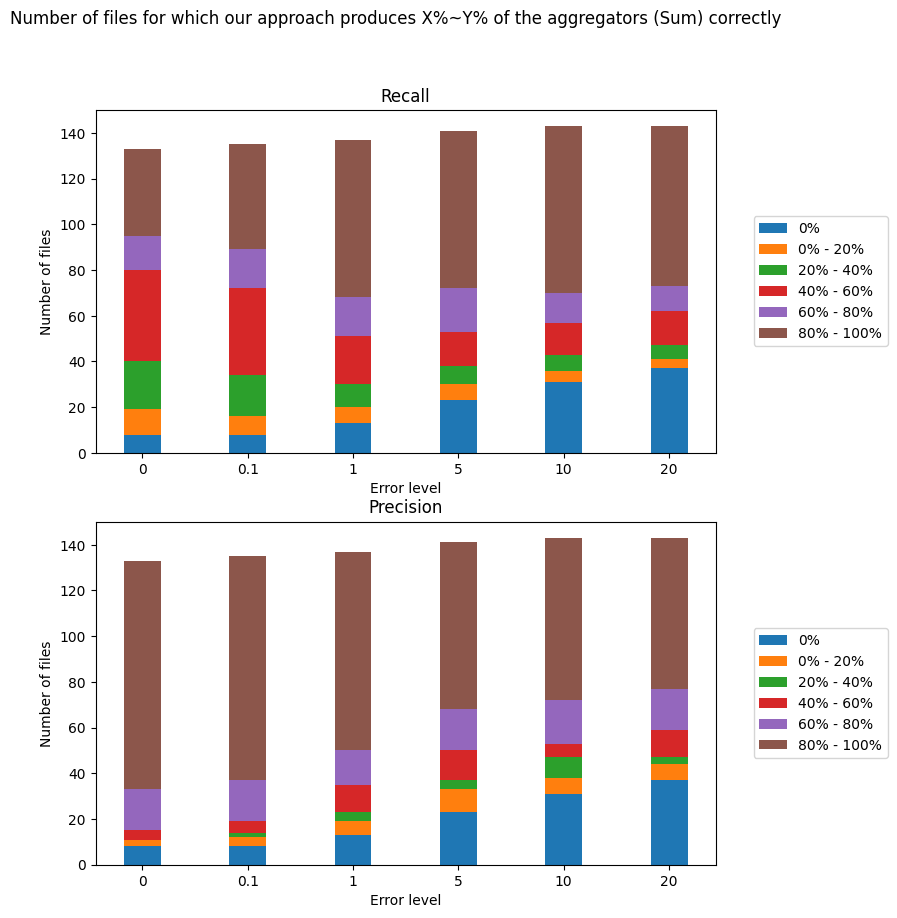

In [496]:
labels = [i[0] for i in file_percent_dist_correctness]
print(labels)

x = np.arange(len(labels))
width = 0.35

fig, (ax1, ax2) = plt.subplots(2, figsize=[8, 10])

le_0_dist = [dist[1][0] for dist in file_percent_dist_correctness]
le_20_dist = [dist[1][1] for dist in file_percent_dist_correctness]
le_40_dist = [dist[1][2] for dist in file_percent_dist_correctness]
le_60_dist = [dist[1][3] for dist in file_percent_dist_correctness]
le_80_dist = [dist[1][4] for dist in file_percent_dist_correctness]
le_100_dist = [dist[1][5] for dist in file_percent_dist_correctness]

p11 = ax1.bar(x, le_0_dist, width)
p12 = ax1.bar(x, le_20_dist, width, bottom=le_0_dist)
p13 = ax1.bar(x, le_40_dist, width, bottom=[i+j for i, j in zip(le_0_dist, le_20_dist)])
p14 = ax1.bar(x, le_60_dist, width, bottom=[i+j+k for i,j,k in zip(le_0_dist, le_20_dist, le_40_dist)])
p15 = ax1.bar(x, le_80_dist, width, bottom=[i+j+k+m for i,j,k,m in zip(le_0_dist, le_20_dist, le_40_dist, le_60_dist)])
p16 = ax1.bar(x, le_100_dist, width, bottom=[i+j+k+m+n for i,j,k,m,n in zip(le_0_dist, le_20_dist, le_40_dist, le_60_dist, le_80_dist)])
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_xlabel('Error level')
ax1.set_ylabel('Number of files')
ax1.legend((p11[0], p12[0], p13[0], p14[0], p15[0], p16[0]), ('0%', '0% - 20%', '20% - 40%', '40% - 60%', '60% - 80%', '80% - 100%'), 
           loc='center left', bbox_to_anchor=(1.05, 0.5))
ax1.title.set_text('Recall')

le_0_dist_precision = [dist[1][0] for dist in file_percent_dist_precision]
le_20_dist_precision = [dist[1][1] for dist in file_percent_dist_precision]
le_40_dist_precision = [dist[1][2] for dist in file_percent_dist_precision]
le_60_dist_precision = [dist[1][3] for dist in file_percent_dist_precision]
le_80_dist_precision = [dist[1][4] for dist in file_percent_dist_precision]
le_100_dist_precision = [dist[1][5] for dist in file_percent_dist_precision]

p21 = ax2.bar(x, le_0_dist_precision, width)
p22 = ax2.bar(x, le_20_dist_precision, width, bottom=le_0_dist_precision)
p23 = ax2.bar(x, le_40_dist_precision, width, bottom=[i+j for i, j in zip(le_0_dist_precision, le_20_dist_precision)])
p24 = ax2.bar(x, le_60_dist_precision, width, bottom=[i+j+k for i,j,k in zip(le_0_dist_precision, le_20_dist_precision, le_40_dist_precision)])
p25 = ax2.bar(x, le_80_dist_precision, width, bottom=[i+j+k+m for i,j,k,m in zip(le_0_dist_precision, le_20_dist_precision, le_40_dist_precision, le_60_dist_precision)])
p26 = ax2.bar(x, le_100_dist_precision, width, bottom=[i+j+k+m+n for i,j,k,m,n in zip(le_0_dist_precision, le_20_dist_precision, le_40_dist_precision, 
                                                                           le_60_dist_precision, le_80_dist_precision)])
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.set_xlabel('Error level')
ax2.set_ylabel('Number of files')
ax2.legend((p21[0], p22[0], p23[0], p24[0], p25[0], p26[0]), ('0%', '0% - 20%', '20% - 40%', '40% - 60%', '60% - 80%', '80% - 100%'), 
           loc='center left', bbox_to_anchor=(1.05, 0.5))
ax2.title.set_text('Precision')

# Set a title of the current axes.
fig.suptitle('Number of files for which our approach produces X%~Y% of the aggregators (Sum) correctly')

plt.show()

['0', '0.1', '1', '5', '10', '20']


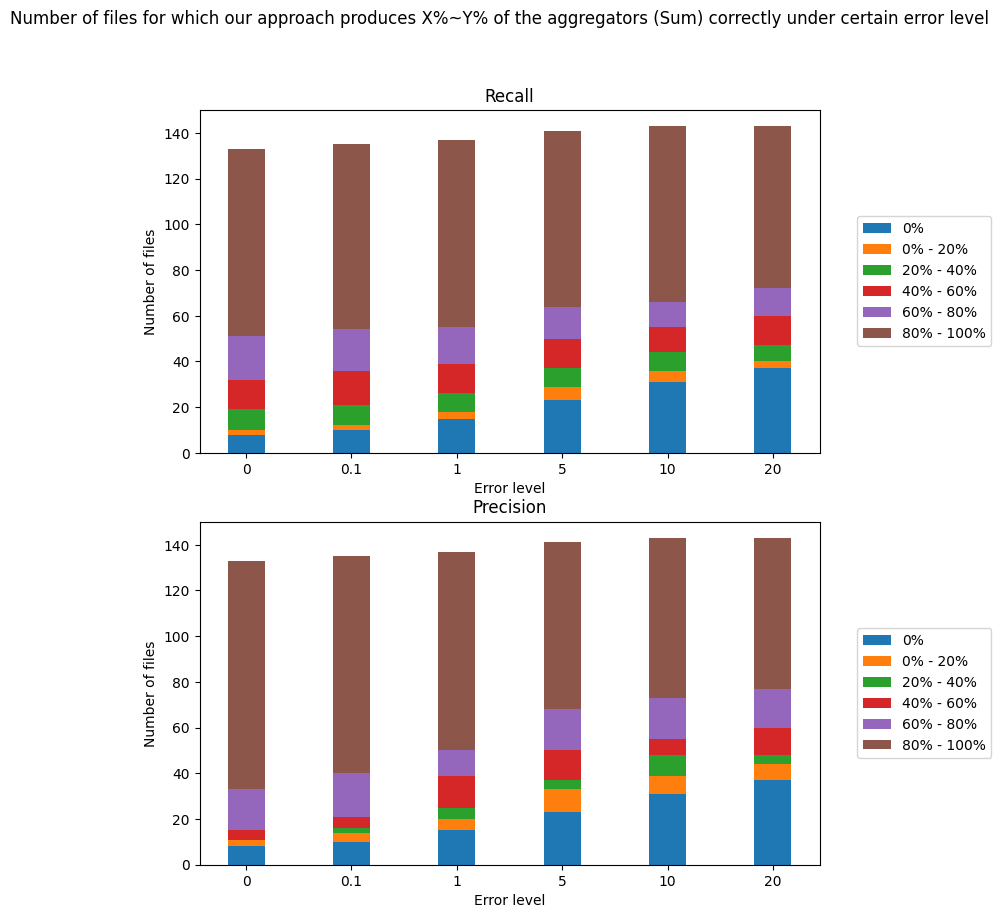

In [497]:
labels = [i[0] for i in file_percent_dist_correctness]
print(labels)

x = np.arange(len(labels))
width = 0.35

fig, (ax1, ax2) = plt.subplots(2, figsize=[8, 10])

le_0_dist = [dist[1][0] for dist in file_percent_dist_correctness_error_bounded]
le_20_dist = [dist[1][1] for dist in file_percent_dist_correctness_error_bounded]
le_40_dist = [dist[1][2] for dist in file_percent_dist_correctness_error_bounded]
le_60_dist = [dist[1][3] for dist in file_percent_dist_correctness_error_bounded]
le_80_dist = [dist[1][4] for dist in file_percent_dist_correctness_error_bounded]
le_100_dist = [dist[1][5] for dist in file_percent_dist_correctness_error_bounded]

p11 = ax1.bar(x, le_0_dist, width)
p12 = ax1.bar(x, le_20_dist, width, bottom=le_0_dist)
p13 = ax1.bar(x, le_40_dist, width, bottom=[i+j for i, j in zip(le_0_dist, le_20_dist)])
p14 = ax1.bar(x, le_60_dist, width, bottom=[i+j+k for i,j,k in zip(le_0_dist, le_20_dist, le_40_dist)])
p15 = ax1.bar(x, le_80_dist, width, bottom=[i+j+k+m for i,j,k,m in zip(le_0_dist, le_20_dist, le_40_dist, le_60_dist)])
p16 = ax1.bar(x, le_100_dist, width, bottom=[i+j+k+m+n for i,j,k,m,n in zip(le_0_dist, le_20_dist, le_40_dist, le_60_dist, le_80_dist)])
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_xlabel('Error level')
ax1.set_ylabel('Number of files')
ax1.legend((p11[0], p12[0], p13[0], p14[0], p15[0], p16[0]), ('0%', '0% - 20%', '20% - 40%', '40% - 60%', '60% - 80%', '80% - 100%'), 
           loc='center left', bbox_to_anchor=(1.05, 0.5))
ax1.title.set_text('Recall')

le_0_dist_precision = [dist[1][0] for dist in file_percent_dist_precision_error_bounded]
le_20_dist_precision = [dist[1][1] for dist in file_percent_dist_precision_error_bounded]
le_40_dist_precision = [dist[1][2] for dist in file_percent_dist_precision_error_bounded]
le_60_dist_precision = [dist[1][3] for dist in file_percent_dist_precision_error_bounded]
le_80_dist_precision = [dist[1][4] for dist in file_percent_dist_precision_error_bounded]
le_100_dist_precision = [dist[1][5] for dist in file_percent_dist_precision_error_bounded]

p21 = ax2.bar(x, le_0_dist_precision, width)
p22 = ax2.bar(x, le_20_dist_precision, width, bottom=le_0_dist_precision)
p23 = ax2.bar(x, le_40_dist_precision, width, bottom=[i+j for i, j in zip(le_0_dist_precision, le_20_dist_precision)])
p24 = ax2.bar(x, le_60_dist_precision, width, bottom=[i+j+k for i,j,k in zip(le_0_dist_precision, le_20_dist_precision, le_40_dist_precision)])
p25 = ax2.bar(x, le_80_dist_precision, width, bottom=[i+j+k+m for i,j,k,m in zip(le_0_dist_precision, le_20_dist_precision, le_40_dist_precision, le_60_dist_precision)])
p26 = ax2.bar(x, le_100_dist_precision, width, bottom=[i+j+k+m+n for i,j,k,m,n in zip(le_0_dist_precision, le_20_dist_precision, le_40_dist_precision, 
                                                                           le_60_dist_precision, le_80_dist_precision)])
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.set_xlabel('Error level')
ax2.set_ylabel('Number of files')
ax2.legend((p21[0], p22[0], p23[0], p24[0], p25[0], p26[0]), ('0%', '0% - 20%', '20% - 40%', '40% - 60%', '60% - 80%', '80% - 100%'), 
           loc='center left', bbox_to_anchor=(1.05, 0.5))
ax2.title.set_text('Precision')

# Set a title of the current axes.
fig.suptitle('Number of files for which our approach produces X%~Y% of the aggregators (Sum) correctly under certain error level')

plt.show()

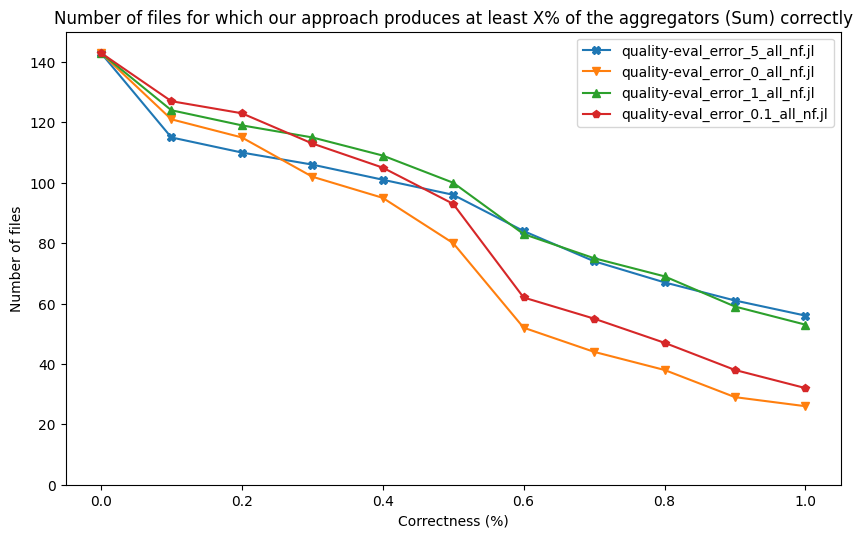

In [166]:
# plt.plot(intervals, [t[1] for t in y[0][1]], marker='*', label = y[0][0])
# plt.plot(intervals, [t[1] for t in y[1][1]], marker='+', label = y[1][0])
plt.plot(intervals, [t[1] for t in y[2][1]], marker='X', label = y[2][0])
# plt.plot(intervals, [t[1] for t in y[3][1]], marker='o', label = y[3][0])
plt.plot(intervals, [t[1] for t in y[4][1]], marker='v', label = y[4][0])
# plt.plot(intervals, [t[1] for t in y[5][1]], marker='d', label = y[5][0])
plt.plot(intervals, [t[1] for t in y[6][1]], marker='^', label = y[6][0])
plt.plot(intervals, [t[1] for t in y[7][1]], marker='p', label = y[7][0])

plt.xlabel('Correctness (%)')
# Set the y axis label of the current axis.
plt.ylabel('Number of files')
# Set a title of the current axes.
plt.title('Number of files for which our approach produces at least X% of the aggregators (Sum) correctly')

axes = plt.gca()
axes.set_ylim([0,150])

plt.legend()
plt.show()

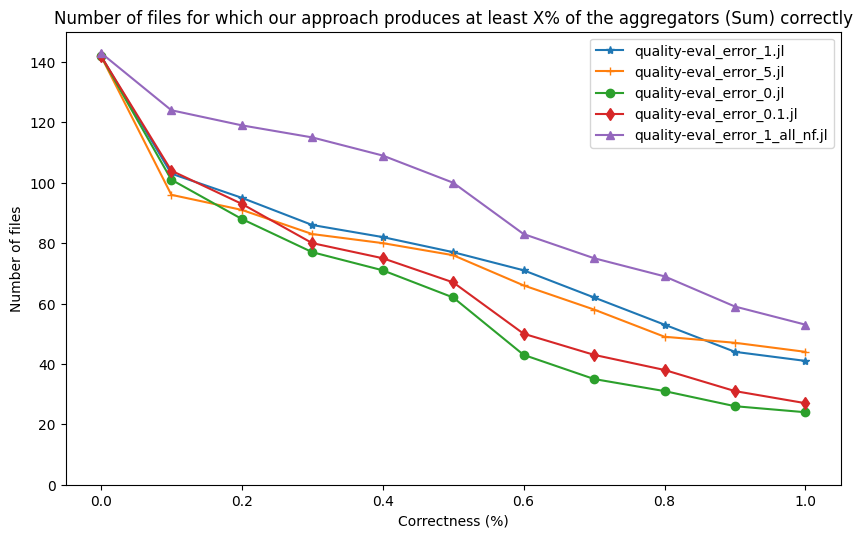

In [169]:
plt.plot(intervals, [t[1] for t in y[0][1]], marker='*', label = y[0][0])
plt.plot(intervals, [t[1] for t in y[1][1]], marker='+', label = y[1][0])
# plt.plot(intervals, [t[1] for t in y[2][1]], marker='X', label = y[2][0])
plt.plot(intervals, [t[1] for t in y[3][1]], marker='o', label = y[3][0])
# plt.plot(intervals, [t[1] for t in y[4][1]], marker='v', label = y[4][0])
plt.plot(intervals, [t[1] for t in y[5][1]], marker='d', label = y[5][0])
plt.plot(intervals, [t[1] for t in y[6][1]], marker='^', label = y[6][0])
# plt.plot(intervals, [t[1] for t in y[7][1]], marker='p', label = y[7][0])

plt.xlabel('Correctness (%)')
# Set the y axis label of the current axis.
plt.ylabel('Number of files')
# Set a title of the current axes.
plt.title('Number of files for which our approach produces at least X% of the aggregators (Sum) correctly')

axes = plt.gca()
axes.set_ylim([0,150])

plt.legend()
plt.show()

In [47]:
os.chdir('../../notebooks/')

In [104]:
file_path = '/Users/lan/Documents/hpi/projects/aggregation-detection/code/aggregation-detection/aggrdet/results/quality-eval_error_1_full_nf.jl'

import pandas

l_val = []

with open(file_path, 'r') as file_reader:
    dicts = [json.loads(line) for line in file_reader]
    for d in dicts:
#         print(d['file_name'])
        values = np.array(d['table_array'])
        file_size = values.shape[0] * values.shape[1]
        gts = d['aggregation_annotations']
        sum_subtract_count = 0
        if gts is None:
            continue
        for gt in gts:
            if gt['operator'] == 'Sum' or gt['operator'] == 'Subtract':
                sum_subtract_count += 1
        if sum_subtract_count == 0:
            continue
        num_correct = len(d['correct'])
        num_incorrect = len(d['incorrect'])
        correct_percent = num_correct / (num_correct + num_incorrect)
        l_val.append([sum_subtract_count, num_correct, num_incorrect, correct_percent, file_size])

In [120]:
df = pandas.DataFrame(l_val, columns=['Number of aggregators', 'Number of correct', 'Number of incorrect', 'Correct percentage', 'File size'])
df = df.sort_values(by=['Correct percentage', 'Number of aggregators']).reset_index(drop=True)

In [121]:
df.to_csv('/Users/lan/Documents/hpi/projects/aggregation-detection/experiments/tableau/troy_sum_correct_analysis.csv', index=True)